# Default Prediction Models with MLI

The data is taken from https://www.kaggle.com/c/south-german-credit-prediction/overview. The objective is to predict if the customer will default on their credit in the bank. One of the aim of this notebook is not only to achieve high accuracy of prediction, but also to provide an interpretable model as it is important in the financial institution according to the EU regulation, whenever Machine Learning are used for decision making, institution need to be able to have transparency on how machine learning make the decission.

**Tools:** 
- Lazy Classifier
- **Visualization:** plotly
- **Machine Learning Interpretability:** SHAP & LIME

# Importing the Library

In [98]:
import pyforest

In [105]:
#Library Import
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [106]:
#Data Loading
df = pd.read_csv('data.csv')
df0 = pd.read_csv('SouthGermanCredit.csv')

print(df['credit_risk'].value_counts())
display(df.head(2))

1    700
0    300
Name: credit_risk, dtype: int64


duration  amount  employment_duration  installment_rate  present_residence  \
0        18    1049                    2                 4                  4   
1         9    2799                    3                 2                  2   

   property  age  number_credits  job  people_liable  credit_risk  status_1  \
0         2   21               1    3              2            1         1   
1         1   36               2    3              1            1         1   

   status_2  status_3  status_4  credit_history_0  credit_history_1  \
0         0         0         0                 0                 0   
1         0         0         0                 0                 0   

   credit_history_2  credit_history_3  credit_history_4  purpose_0  purpose_1  \
0                 0                 0                 1          0          0   
1                 0                 0                 1          1          0   

   purpose_2  purpose_3  purpose_4  purpose_5  purpose_6  purpose_8  \
0          1          0          0          0          0          0   
1          0          0          0          0          0          0   

   purpose_9  purpose_10  savings_1  savings_2  savings_3  savings_4  \
0          0           0          1          0          0          0   
1          0           0          1          0          0          0   

   savings_5  personal_status_sex_1  personal_status_sex_2  \
0          0                      0                      1   
1          0                      0                      0   

   personal_status_sex_3  personal_status_sex_4  other_debtors_1  \
0                      0                      0                1   
1                      1                      0                1   

   other_debtors_2  other_debtors_3  other_installment_plans_1  \
0                0                0                          0   
1                0                0                          0   

   other_installment_plans_2  other_installment_plans_3  housing_1  housing_2  \
0                          0                          1          1          0   
1                          0                          1          1          0   

   housing_3  telephone_1  telephone_2  foreign_worker_1  foreign_worker_2  
0          0            1            0                 0                 1  
1          0            1            0                 0                 1

In [107]:
df['credit_risk'] = df.credit_risk.map({1:0, 0:1})
df0['credit_risk'] = df0.credit_risk.map({1:0, 0:1})

# Preprocess

In [108]:
#Oversampling for default cases (Here 1 as non-default and while 0 as default)
default_oversample = df[df['credit_risk'] == 1].sample(frac=7/3, replace= True)

#Back to the dataset
df = default_oversample.append(df[df['credit_risk'] == 0], ignore_index=True)
df['credit_risk'].value_counts() #Checking

1    700
0    700
Name: credit_risk, dtype: int64

In [109]:
X = df.drop(['credit_risk'], axis=1)
y = df['credit_risk']

In [110]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#70% training, 10% validation, 20% testing

In [112]:
print("Number of loans in training set: {}".format(len(X_train)))
print("Number of loans in testing set: {}".format(len(X_test)))

Number of loans in training set: 1120
Number of loans in testing set: 280


# Exploratory Data Analysis

In [113]:
print("credit_risk = 0 = good")
print("credit_risk = 1 = bad")

credit_risk = 0 = good
credit_risk = 1 = bad


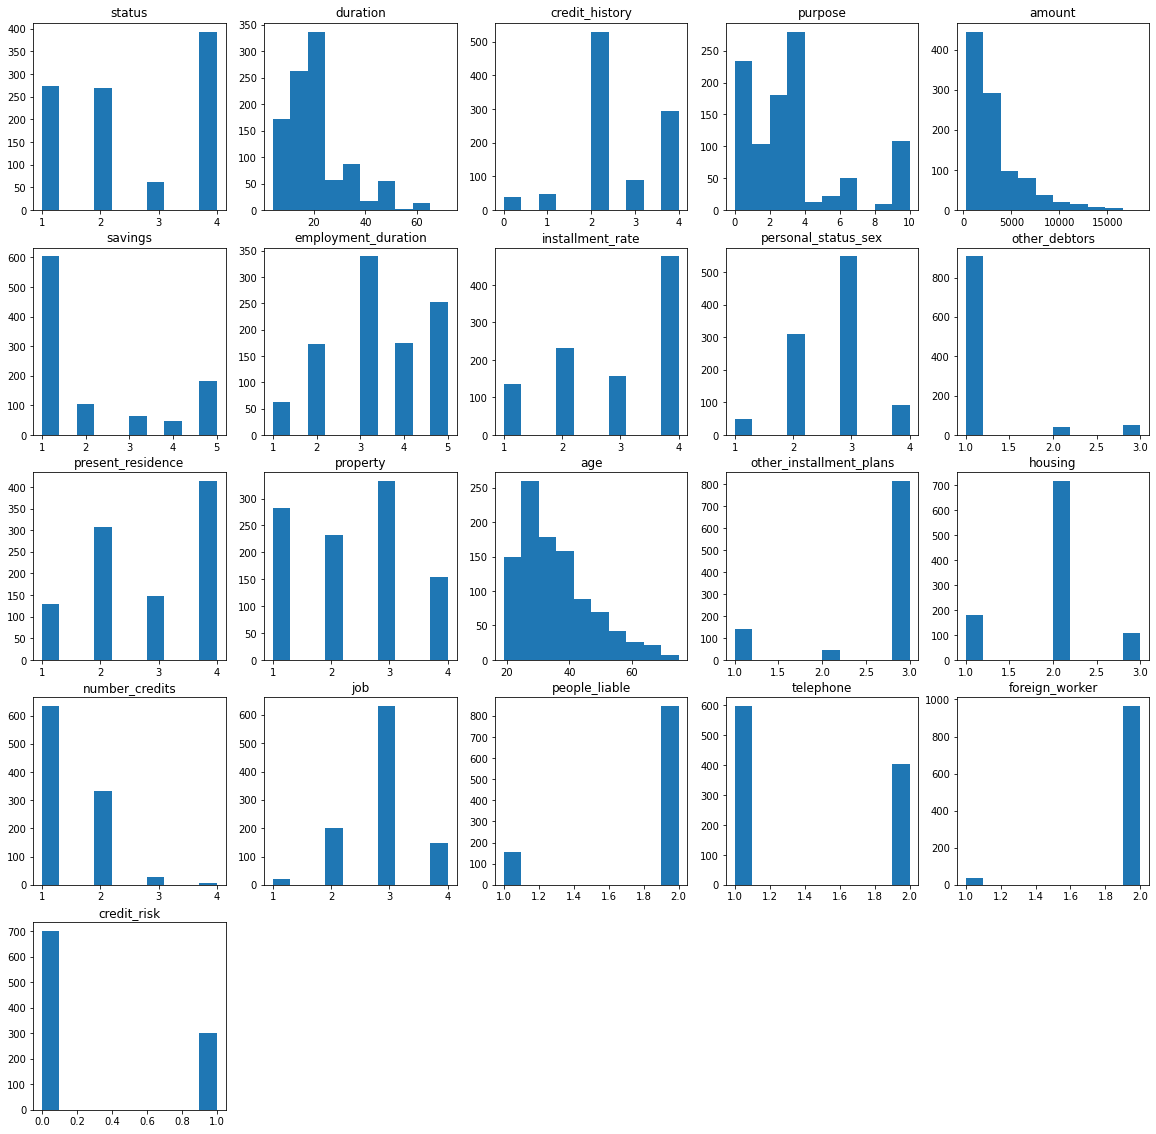

In [114]:
features = ['status', 'duration', 'credit_history', 'purpose',
       'amount', 'savings', 'employment_duration', 'installment_rate',
       'personal_status_sex', 'other_debtors', 'present_residence', 'property',
       'age', 'other_installment_plans', 'housing', 'number_credits', 'job',
       'people_liable', 'telephone', 'foreign_worker', 'credit_risk']

plt.figure(figsize = (20,20))
for i,feature in enumerate(features):
    plt.subplot(5, 5,i+1)
    plt.title(feature)
    plt.hist(df0[feature])
plt.show()

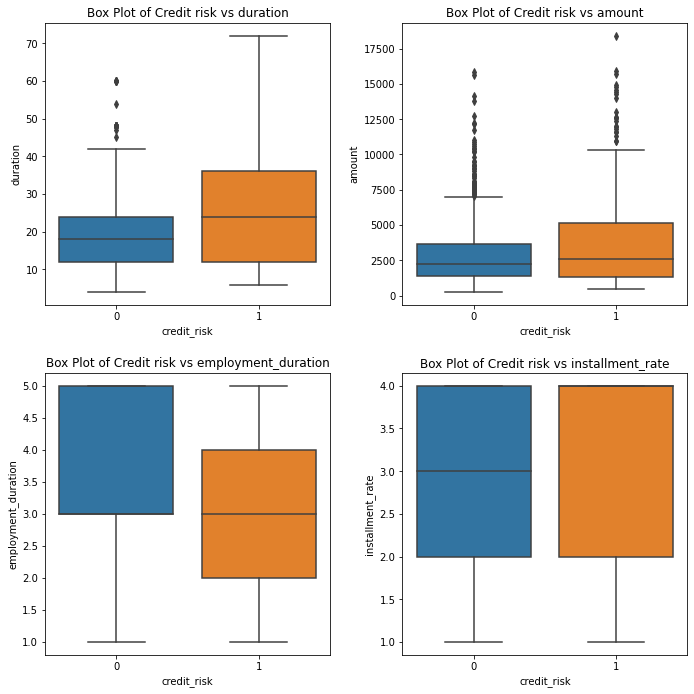

In [115]:
features = ['duration', 'amount', 'employment_duration', 'installment_rate']

plt.figure(figsize = (10,10))
for i,feature in enumerate(features):
    plt.subplot(2,2,i+1)
    sns.boxplot(x = 'credit_risk', y = feature, data = df0)
    plt.title('Box Plot of Credit risk vs ' + feature)
    plt.tight_layout(pad = 2)
plt.show()

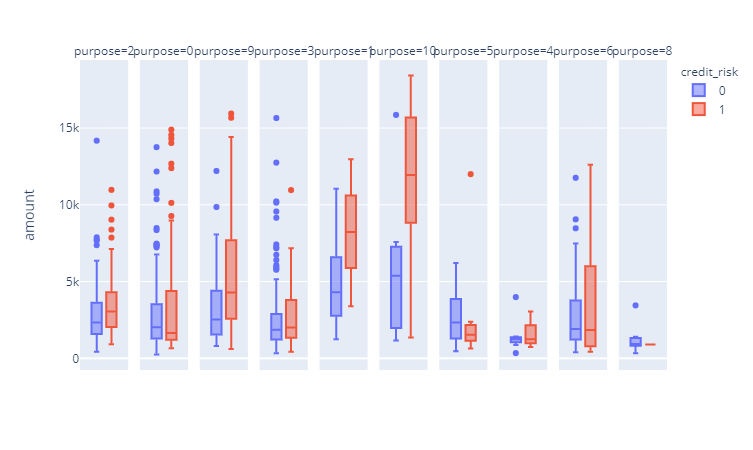

In [116]:
import plotly.express as px

px.box(df0, facet_col = 'purpose', color = 'credit_risk', y='amount')
# px.scatter(df0, x = 'duration', y='amount')

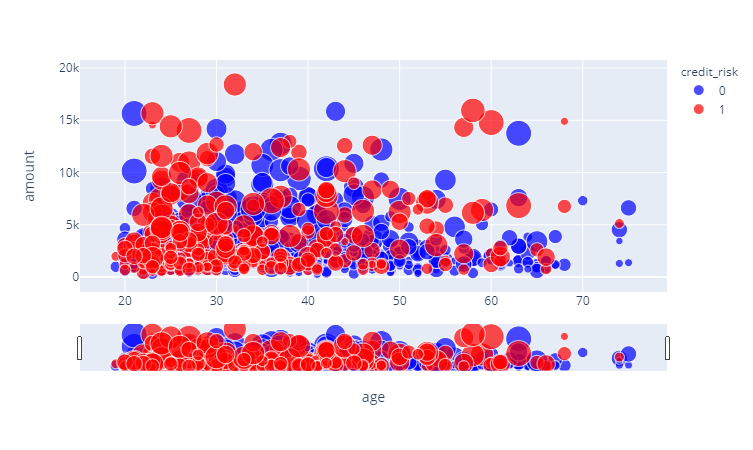

In [117]:
df_viz = df0.copy()
df_viz['credit_risk'] = df_viz.credit_risk.astype(str)
fig = px.scatter(df_viz, x = 'age', y = 'amount', 
                 color = 'credit_risk', size = 'duration', 
                 color_discrete_sequence= ["blue",  "red"])
fig.update_xaxes(rangeslider_visible = True)

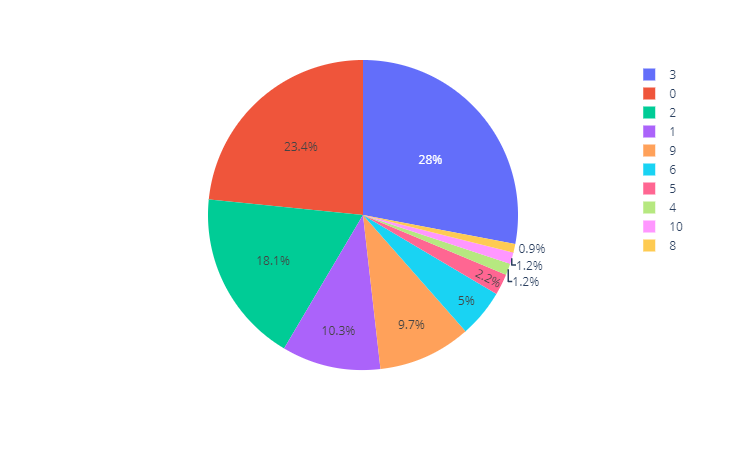

In [118]:
df_viz = df0[['status', 'purpose']].groupby('purpose').count().reset_index(drop = False)
px.pie(df_viz, values = 'status', names = 'purpose')

# Model

In [119]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [120]:
clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 16.02it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.93               0.93     0.93      0.93   
RandomForestClassifier             0.92               0.92     0.92      0.92   
LGBMClassifier                     0.91               0.92     0.92      0.91   
XGBClassifier                      0.90               0.90     0.90      0.90   
BaggingClassifier                  0.90               0.90     0.90      0.90   
DecisionTreeClassifier             0.87               0.87     0.87      0.87   
LabelPropagation                   0.86               0.86     0.86      0.86   
LabelSpreading                     0.86               0.86     0.86      0.86   
ExtraTreeClassifier                0.84               0.84     0.84      0.83   
NuSVC                              0.84               0.84     0.84      0.83   
SVC                                0.82               0.83     0.83      0.82   
KNeighborsClassifier               0.77               0.77     0.77      0.77   
AdaBoostClassifier                 0.77               0.77     0.77      0.77   
LinearDiscriminantAnalysis         0.77               0.77     0.77      0.77   
RidgeClassifier                    0.77               0.77     0.77      0.77   
RidgeClassifierCV                  0.77               0.77     0.77      0.77   
CalibratedClassifierCV             0.77               0.77     0.77      0.77   
LinearSVC                          0.77               0.77     0.77      0.77   
NearestCentroid                    0.76               0.76     0.76      0.76   
LogisticRegression                 0.76               0.76     0.76      0.76   
GaussianNB                         0.76               0.76     0.76      0.76   
BernoulliNB                        0.75               0.75     0.75      0.75   
SGDClassifier                      0.74               0.74     0.74      0.74   
Perceptron                         0.73               0.73     0.73      0.73   
PassiveAggressiveClassifier        0.69               0.69     0.69      0.69   
QuadraticDiscriminantAnalysis      0.64               0.65     0.65      0.62   
DummyClassifier                    0.51               0.51     0.51      0.51   

                               Time Taken  
Model                                      
ExtraTreesClassifier                 0.14  
RandomForestClassifier               0.16  
LGBMClassifier                       0.06  
XGBClassifier                        0.09  
BaggingClassifier                    0.05  
DecisionTreeClassifier               0.02  
LabelPropagation                     0.06  
LabelSpreading                       0.10  
ExtraTreeClassifier                  0.01  
NuSVC                                0.09  
SVC                                  0.07  
KNeighborsClassifier                 0.05  
AdaBoostClassifier                   0.11  
LinearDiscriminantAnalysis           0.02  
RidgeClassifier                      0.02  
RidgeClassifierCV                    0.03  
CalibratedClassifierCV               0.45  
LinearSVC                            0.13  
NearestCentroid                      0.01  
LogisticRegression                   0.02  
GaussianNB                           0.00  
BernoulliNB                          0.01  
SGDClassifier                        0.02  
Perceptron                           0.01  
PassiveAggressiveClassifier          0.01  
QuadraticDiscriminantAnalysis        0.03  
DummyClassifier                      0.01

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

param = {'max_depth' : [5, 10, 15],
        'n_estimators' : [50, 100, 200],
        'max_features' : ['auto', 'sqrt'],
        'min_samples_leaf' : [2, 5, 10]}

rf_random = RandomizedSearchCV(estimator = rf,
                                param_distributions = param,
                                n_iter = 100,
                                cv = 3,
                                verbose = 2,
                                random_state =1,
                                n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    3.9s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=1, verbose=2)

In [122]:
best_model = rf_random.best_estimator_
print(best_model)
pred = best_model.predict(X_test)

RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=50)


In [123]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score

print("roc_auc score:\t", roc_auc_score(y_test, pred))
print("accuracy \t", accuracy_score(y_test, pred))
print("classification report: \n", classification_report(y_test, pred))

roc_auc score:	 0.8938798427849524
accuracy 	 0.8928571428571429
classification report: 
               precision    recall  f1-score   support

           0       0.94      0.85      0.89       143
           1       0.85      0.94      0.90       137

    accuracy                           0.89       280
   macro avg       0.90      0.89      0.89       280
weighted avg       0.90      0.89      0.89       280



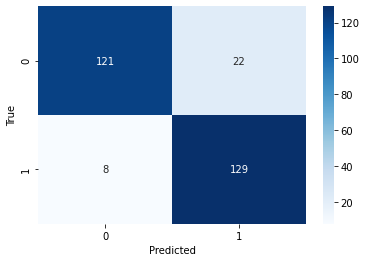

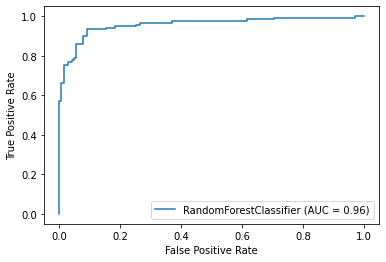

In [124]:
from sklearn import metrics 

ax = sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues', fmt='g')
ax.set(xlabel='Predicted', ylabel='True')
plt.show()

metrics.plot_roc_curve(best_model, X_test, y_test)  
plt.show()

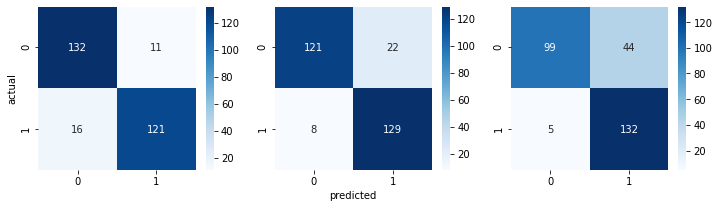

In [125]:
pred_prob = best_model.predict_proba(X_test)[:,0]
pred_40 = [0 if prob >= 0.4 else 1 for prob in pred_prob ]
pred_60 = [0 if prob >= 0.6 else 1 for prob in pred_prob ]

plt.figure(figsize = (12,3))

plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_test, pred_40), annot=True, cmap='Blues', fmt='g')
plt.ylabel('actual')
plt.subplot(1,3,2)
sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues', fmt='g')
plt.xlabel('predicted')
plt.subplot(1,3,3)
sns.heatmap(confusion_matrix(y_test, pred_60), annot=True, cmap='Blues', fmt='g')
plt.show()

# Machine Learning Interpretation

## SHAP

In [126]:
import shap
import numpy as np

shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

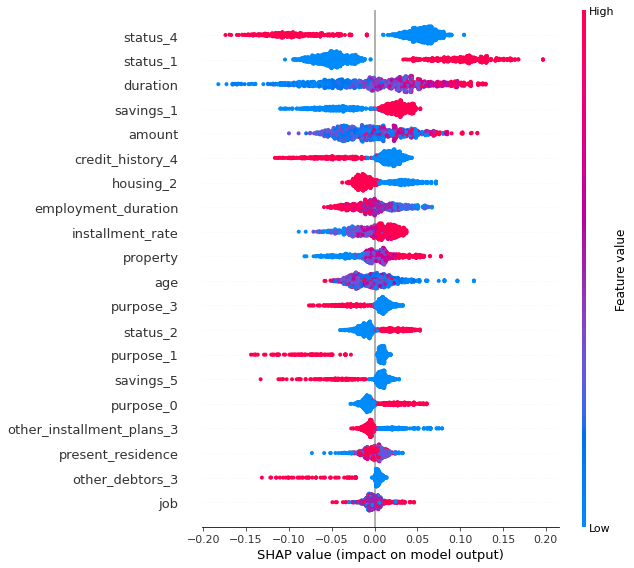

In [127]:
shap.summary_plot(shap_values[1], X_train)

In [128]:
shap_values = explainer.shap_values(X_test)

def individual_force_plot(j):
    shap.initjs()
    y_row = pred[j]
    chart = shap.force_plot(explainer.expected_value[1], shap_values[1][j], features = X_test.iloc[j], feature_names = X_test.columns)
    print('prediction:', y_row)
    print('actual:', y_test.iloc[j])
    
    return chart

In [129]:
individual_force_plot(5)

prediction: 0
actual: 0


In [133]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], feature_names = X_test.columns) 

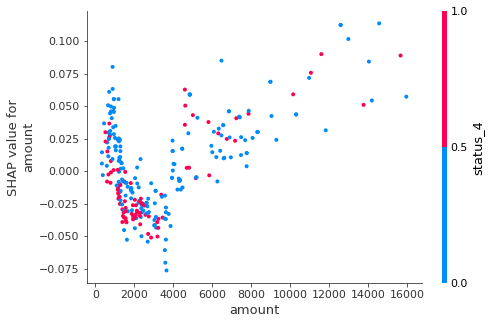

In [134]:
shap.dependence_plot("amount", shap_values[1], X_test)

## Lime

In [135]:
import lime
import lime.lime_tabular

In [136]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names = X_train.columns,
                                                   class_names=['default','not default'],kernel_width=5)

In [137]:
chosen_instance = X_test.iloc[0]

In [139]:
pred_func = lambda x: best_model.predict_proba(x).astype(float)

exp_lime = explainer_lime.explain_instance(chosen_instance, pred_func, num_features=10)
exp_lime.show_in_notebook(show_all=False)